# Breast Dataset

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import preprocess
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
from tqdm import tqdm
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data

In [2]:
x, y, _, _ = preprocess.get_data(100)

## Deep Forest

In [3]:
model = deep_forest.DeepForest(100, 2, 30, 0.25, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [4]:
optimizer = th.optim.Adam(model.parameters())
pbar = tqdm(range(2500))
for i in pbar:
    model.populate_best(x[:, :], y[:])
    optimizer.zero_grad()

    loss = model.loss(x[:, :], y[:], device)
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((model.forward(x[:, :], device) == y[:]).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(x[:, :], device) == y[:]).float())))

  0%|          | 0/2500 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH 2499 || Acc: tensor(0.9789) || Loss: tensor([292.2313], grad_fn=<AddBackward0>): 100%|██████████| 2500/2500 [41:31<00:00,  1.00it/s]



FINAL ACC: tensor(0.9789)


In [5]:
imp = model.compute_importance(x)
print()
print(imp)

100%|██████████| 100/100 [07:54<00:00,  4.74s/it]


defaultdict(<function DeepForest.__init__.<locals>.<lambda> at 0x7fab48b552f0>, {6: 0.02813572820679641, 17: 0.0028606337854497196, 4: 0.0017406404367935858, 20: 0.089362021364029, 2: 0.10287282299483139, 27: 0.025708718258940513, 26: 0.029797935794141965, 8: 0.002710275561611711, 10: 0.026266647696560858, 11: 0.008274821380290103, 12: 0.027425102584825355, 28: 0.008712480710909446, 16: 0.0035584697849436625, 22: 0.0768191575027144, 7: 0.016456269086300192, 5: 0.009686612048724884, 9: 0.002615765833087783, 14: 0.0004827227331916703, 25: 0.014430556393122105, 21: 0.02594545817884116, 1: 0.009992552011038769, 24: 0.006270752672345851, 15: 0.003962658138382597, 29: 0.0020787116239987897, 18: 0.0013862299237403133, 19: 0.0013504927303384414, 0: 0.07282489532452559, 13: 0.05626899407742721, 23: 0.1944017384212526, 3: 0.14760013474084402})


Text(0.5, 1.0, 'Breast Deep Forest Importance')

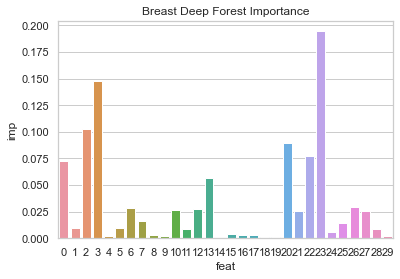

In [10]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data).set_title("Breast Deep Forest Importance")

## MLP Baseline

In [7]:
mlp = nn.Sequential(
    nn.Linear(30, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()

    preds = mlp(x)
    loss = nn.functional.cross_entropy(preds, y)
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((th.argmax(mlp(x), 1) == y).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

  0%|          | 0/1000 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH 999 || Acc: tensor(0.6274) || Loss: tensor(0.6858, grad_fn=<NllLossBackward>): 100%|██████████| 1000/1000 [00:06<00:00, 155.20it/s]



FINAL ACC: tensor(0.6274)


## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.9648506151142355


Text(0.5, 1.0, 'Breast Random Forest Importance')

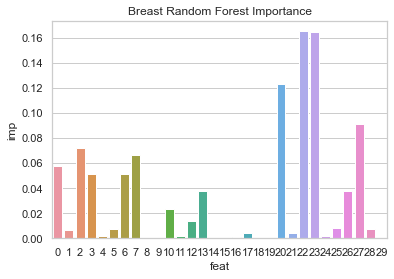

In [31]:
data = pd.DataFrame({"feat": list(range(30)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data).set_title("Breast Random Forest Importance")